In [1]:
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torchtext
from torchtext.vocab import build_vocab_from_iterator
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split


import itertools

from nltk.metrics import distance
import seaborn as sns
import matplotlib.pyplot as plt


# Data

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cpu'

In [3]:
data = pd.read_csv('csv/train.csv')
data

,Unnamed: 0,word,lemma,pos_tag,freq,word_length,lemma_length,ratio,lemma_length_category,word_length_category,ratio_category,reported_speech,freq_category
0,1104841,მონოზონისა,მონოზონი,N,1,10,8,1.250000,medium,medium,greater,False,low
1,1260770,სამხრეთიდგან,სამხრეთი,N,1,12,8,1.500000,medium,high,greater,False,low
2,637615,მოფიქრებაშია,მოფიქრება,N,1,12,9,1.333333,medium,high,greater,False,low
3,79017,სიდიადეს,სიდიადე,N,209,8,7,1.142857,low,low,greater,False,high
4,1107010,განგსტერებისათვის,განგსტერი,N,2,17,9,1.888889,medium,high,greater,False,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
956889,485527,ტონგას,ტონგა,N,102,6,5,1.200000,low,low,greater,False,high
956890,113442,ადენა,ადენა,N,5,5,5,1.000000,low,low,equal,False,medium
956891,131905,ვრაცხ,*რაცხვა,V,46,5,7,0.714286,low,low,less,False,medium
956892,1049224,ამოდგომაც,ამოდგომა,N,1,9,8,1.125000,medium,low,greater,False,low


In [4]:
word, lemma = data.iloc[0]['word'], data.iloc[0]['lemma']
word, lemma

('მონოზონისა', 'მონოზონი')

In [10]:
distance.edit_distance_align('ეს', 'ესეთი')

[(0, 0), (1, 1), (2, 2), (2, 3), (2, 4), (2, 5)]

In [219]:
data = data[['word', 'lemma']]
data['edit_distance'] = data.apply(lambda x: distance.edit_distance(x.word, x.lemma), axis=1)

/var/tmp/ipykernel_22626/957830015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['edit_distance'] = data.apply(lambda x: distance.edit_distance(x.word, x.lemma), axis=1)


<Axes: xlabel='edit_distance', ylabel='count'>

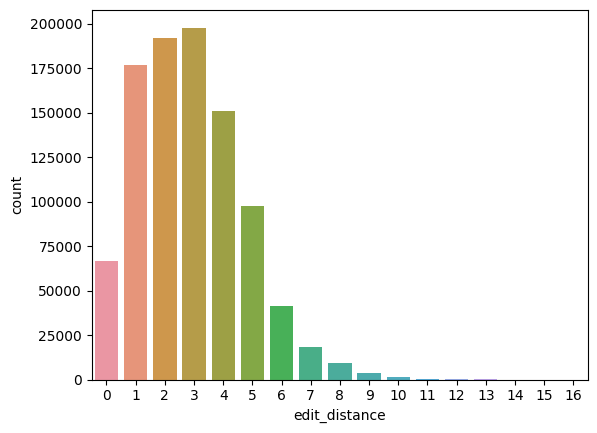

In [220]:
sns.countplot(data, x ='edit_distance')

In [5]:
MAX_LENGTH = data.word.str.len().max()
MAX_LENGTH

32

In [196]:
def get_tokens(t):
    yield from list(t)

UNK_TOKEN = '<unk>'
EOW_TOKEN = '<end>'
PAD_TOKEN = '<pad>'
SOW_TOKEN = '<start>'

vocab = build_vocab_from_iterator(iterator=get_tokens(itertools.chain(data['word'], data['lemma'])),
                                  specials=[EOW_TOKEN, UNK_TOKEN, PAD_TOKEN, SOW_TOKEN],
                                  special_first=False
                                  )
vocab.set_default_index(vocab[UNK_TOKEN])

def word_to_seq(word: str):
    return torch.tensor(vocab(list(word)) + [vocab[EOW_TOKEN]])

In [197]:
BATCH_SIZE = 128
RANDOM_STATE = 42

In [198]:
class LemmaDataSet(Dataset):
    def __init__(self, data_frame: pd.DataFrame):
        self.data = data_frame

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> (str, str):
        row = self.data.iloc[idx]
        return row['word'], row['lemma']


In [209]:
def coallate_words(batch):
    word_list, lemma_list = [torch.zeros(MAX_LENGTH, dtype=torch.int64)], [torch.zeros(MAX_LENGTH, dtype=torch.int64)]
    for word, lemma in batch:
        word_list.append(word_to_seq(word))
        lemma_list.append(word_to_seq(lemma))


    return pad_sequence(word_list, batch_first=True, padding_value=vocab[PAD_TOKEN])[1:], pad_sequence(lemma_list, batch_first=True, padding_value=vocab[PAD_TOKEN])[1:]

In [210]:
train_data, val_data = train_test_split(data, random_state=RANDOM_STATE, train_size=0.8, shuffle=True)
train_loader = DataLoader(LemmaDataSet(train_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=coallate_words, pin_memory=True)
val_loader = DataLoader(LemmaDataSet(val_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=coallate_words, pin_memory=True)

# Model

In [211]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_dim, emb_dim,  hidden_dim, num_layers=1):
        super(EncoderRNN, self).__init__()

        # set dimensions
        self.hidden_size = hidden_dim
        self.embedding_size = emb_dim
        self.vocab_size = vocab_dim
        self.num_layers = num_layers

        # initialize layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
        self.gru = nn.GRU(self.embedding_size, self.hidden_size, num_layers=self.num_layers, batch_first=True)

    def forward(self, input, hidden=None):
        embedded = self.embedding(input)
        if hidden is not None:
            output, hidden = self.gru(embedded, hidden)
        else:
            output, hidden = self.gru(embedded)
        return output, hidden


In [212]:
class DecoderRNN(nn.Module):
    def __init__(self, emb_dim, hidden_dim, vocab_dim, num_layers=1):
        super(DecoderRNN, self).__init__()
        # set dimensions
        self.hidden_size = hidden_dim
        self.embedding_size = emb_dim
        self.output_size = vocab_dim
        self.num_layers = num_layers

        #initialize layers
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size,self.hidden_size, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input, hidden):
        embedding = F.relu(self.embedding(input))
        output, hidden = self.gru(embedding, hidden)
        pred = self.softmax(self.out(output))
        return pred, hidden



In [213]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device='cpu'):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
#         self.decoder.embedding = self.encoder.embedding  # 
        self.device = device

    def forward(self, source, target=None, teacher_forcing_ratio=0.5):
        input_length = source.size(1) 
        batch_size = source.size(0)
        vocab_size = self.encoder.vocab_size

        #initialize a variable to hold the predicted outputs
        outputs = []
        encoder_output, encoder_hidden = self.encoder(source[:, 0].unsqueeze(1))
        #encode every word in a sentence
        for i in range(1, input_length):
            encoder_output, encoder_hidden = self.encoder(source[:, i].unsqueeze(1), encoder_hidden)

        #use the encoder’s hidden layer as the decoder hidden
        decoder_hidden = encoder_hidden.to(device)

        #add a start_of_the_word token before the first predicted word
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(vocab[SOW_TOKEN])

        for t in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs.append(decoder_output)
            _, topi = decoder_output.topk(1)
            if target is not None and target.size(1) > t:
                teacher_force = random.random() < teacher_forcing_ratio
                target_input = target[:, t].unsqueeze(1)
                decoder_input = (target_input if teacher_force else topi.squeeze(-1).detach())
            else:
                decoder_input = topi.squeeze(-1).detach()
        return torch.cat(outputs, dim=1)


In [214]:
model = Seq2Seq(EncoderRNN(vocab_dim=len(vocab), emb_dim=64 ,hidden_dim=64).to(device), DecoderRNN(vocab_dim=len(vocab), emb_dim=64, hidden_dim=64).to(device), device=device)
print(f'Number of Parameters: {sum(p.numel() for p in model.parameters())}')

Number of Parameters: 57447


# Train

In [215]:

def train_epoch(dataloader, model, optimizer, criterion):
    model.train()
    
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        
        optimizer.zero_grad()

        decoder_outputs = model(input_tensor, target_tensor)
        
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        

    return total_loss / len(dataloader)

def validate_epoch(dataloader, model, criterion):
    model.eval()
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        
        decoder_outputs = model(input_tensor)
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        total_loss += loss.item() 
        
    return total_loss / len(val_loader)

In [216]:
from torch import optim
from datetime import datetime


def train(train_loader, val_loader,  model, n_epochs, learning_rate=0.001,
          display_every=1):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    
    iter_train_loss = 0
    iter_val_loss = 0
    plot_train_loss = []
    plot_val_loss = []

    start = datetime.now()
    for epoch in range(1, n_epochs + 1):
        train_loss = train_epoch(train_loader, model, optimizer, criterion)
        val_loss = validate_epoch(val_loader, model, criterion)
        iter_train_loss += train_loss
        iter_val_loss += val_loss
        
        if epoch % display_every == 0:
            train_avg = iter_train_loss / display_every
            train_total = iter_train_loss
            val_avg = iter_val_loss / display_every
            val_total = iter_val_loss
            plot_train_loss.append(train_avg)
            iter_train_loss = 0
            plot_val_loss.append(val_avg)
            iter_val_loss = 0
            
            print(f'Epoch: {epoch}: Train Loss: {train_total}, Validation Loss: {val_total},\
            Train AVG Loss: {train_avg}, Validation AVG Loss: {val_avg},\
            Time Elapsed: {(datetime.now() - start).total_seconds() / 60}M')
            start = datetime.now()
    
    return model, plot_val_loss, plot_train_loss

In [217]:
VERSION = 0
model,graph_val, graph_train,  = train(train_loader, val_loader, model.to(device), 50, learning_rate=0.001)
torch.save(model.state_dict(), f'Lemmatization/weights/base_model_v{VERSION}.pt')

Epoch: 1: Train Loss: 0.9664386556581464, Validation Loss: 1.0065408274531364,            Train AVG Loss: 0.9664386556581464, Validation AVG Loss: 1.0065408274531364,            Time Elapsed: 0.66298785M
Epoch: 2: Train Loss: 0.7460095149171931, Validation Loss: 0.8431869089603424,            Train AVG Loss: 0.7460095149171931, Validation AVG Loss: 0.8431869089603424,            Time Elapsed: 0.6580340333333333M
Epoch: 3: Train Loss: 0.6988199427914437, Validation Loss: 0.8273501679301262,            Train AVG Loss: 0.6988199427914437, Validation AVG Loss: 0.8273501679301262,            Time Elapsed: 0.6532804333333334M
Epoch: 4: Train Loss: 0.6712531487045386, Validation Loss: 0.8172565400600433,            Train AVG Loss: 0.6712531487045386, Validation AVG Loss: 0.8172565400600433,            Time Elapsed: 0.663195M
Epoch: 5: Train Loss: 0.6526340846820256, Validation Loss: 0.7788749501109123,            Train AVG Loss: 0.6526340846820256, Validation AVG Loss: 0.7788749501109123,    

KeyboardInterrupt: 

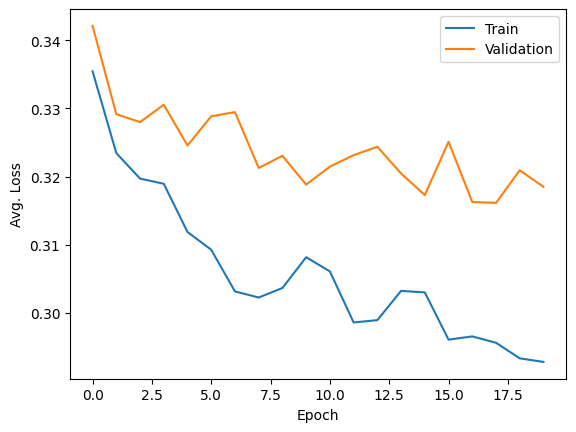

In [142]:
sns.lineplot(graph_train, label='Train')
sns.lineplot(graph_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss')
plt.show()

In [143]:
source, target = next(iter(train_loader))
pred = model(source.to(device), target.to(device)).argmax(dim=2)

In [144]:
source.size(), target.size(), pred.size()

(torch.Size([160, 22]), torch.Size([160, 22]), torch.Size([160, 22]))

In [145]:
[vocab.get_itos()[i] for i in source[0]]

['რ',
 'ა',
 'დ',
 'ი',
 'ო',
 'ს',
 'ი',
 'გ',
 'ნ',
 'ა',
 'ლ',
 'ე',
 'ბ',
 'ს',
 '<end>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [146]:
[vocab.get_itos()[i] for i in pred[0]]

['რ',
 'ა',
 'დ',
 'ი',
 'ო',
 'ნ',
 'ი',
 'ნ',
 'ა',
 'ნ',
 'ლ',
 'ი',
 '<end>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [147]:
[vocab.get_itos()[i] for i in target[0]]

['რ',
 'ა',
 'დ',
 'ი',
 'ო',
 'ს',
 'ი',
 'გ',
 'ნ',
 'ა',
 'ლ',
 'ი',
 '<end>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
vocab.get_itos()

(tensor([0, 3, 2]),
 tensor([[ 0.8605, -0.8043,  0.9290,  0.2762,  1.3111],
         [-1.5824, -0.3551,  0.5694, -0.5948, -0.9864],
         [-0.2881, -0.2128,  0.2438, -1.0952, -0.5630]], requires_grad=True))